<a href="https://colab.research.google.com/github/HoangNguyennnnnnn/ComputerVision/blob/main/MeanFlow_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 MeanFlow CIFAR-10 - Improved Implementation

## Based on Deep Paper Analysis:

**Algorithm 1 (Training):**
```
z = (1-t)*x + t*ε
v = ε - x
u, dudt = jvp(model, (z,r,t), (v,0,1))
u_tgt = v - (t-r)*dudt
loss = MSE(u, stopgrad(u_tgt))
```

**Algorithm 2 (1-step Sampling):**
```
x = ε - model(ε, r=0, t=1)
```

## Key Paper Settings:
- r≠t ratio: 25%
- Conditioning: (t, t-r)
- Sampler: logit-normal(-0.4, 1.0)
- Model: ~55M for CIFAR-10 (we use smaller)

## Fixes in this version:
1. Use `functional_call` for proper JVP with stateful model
2. EMA for stable sampling
3. Adaptive loss weighting (p=1.0)
4. Larger model (more capacity)
5. More iterations per epoch

> ⚠️ Restart runtime before running!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.func import jvp, functional_call
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math, os, copy
import numpy as np

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [2]:
# Dataset - Full CIFAR-10 for more data
def get_dataloader(bs=64, full=True):
    tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    ds = CIFAR10("./data", train=True, download=True, transform=tf)
    if not full:
        # Automobiles only
        idx = [i for i, (_, l) in enumerate(ds) if l == 1]
        ds = Subset(ds, idx)
    return DataLoader(ds, batch_size=bs, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

dl = get_dataloader(bs=64, full=False)  # Start with automobiles
print(f"Dataset: {len(dl.dataset)} images, {len(dl)} batches")

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Dataset: 5000 images, 78 batches


In [3]:
# Improved U-Net
class SinusoidalEmbed(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device) / half)
        emb = t[:, None] * freqs[None, :] * 1000
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch * 2))
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        # Scale and shift with time embedding
        scale, shift = self.time_mlp(t_emb).chunk(2, dim=-1)
        h = h * (1 + scale[:, :, None, None]) + shift[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)

class UNet(nn.Module):
    def __init__(self, ch=64, time_dim=128):
        super().__init__()
        self.time_dim = time_dim

        # Separate embeddings for t and (t-r)
        self.t_embed = nn.Sequential(
            SinusoidalEmbed(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim)
        )
        self.delta_embed = nn.Sequential(
            SinusoidalEmbed(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim)
        )

        # Encoder
        self.conv_in = nn.Conv2d(3, ch, 3, padding=1)
        self.enc1 = ResBlock(ch, ch, time_dim * 2)
        self.down1 = nn.Conv2d(ch, ch, 3, stride=2, padding=1)  # 32->16
        self.enc2 = ResBlock(ch, ch * 2, time_dim * 2)
        self.down2 = nn.Conv2d(ch * 2, ch * 2, 3, stride=2, padding=1)  # 16->8
        self.enc3 = ResBlock(ch * 2, ch * 2, time_dim * 2)

        # Middle
        self.mid1 = ResBlock(ch * 2, ch * 2, time_dim * 2)
        self.mid2 = ResBlock(ch * 2, ch * 2, time_dim * 2)

        # Decoder
        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.dec2 = ResBlock(ch * 4, ch, time_dim * 2)  # concat with enc2
        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.dec1 = ResBlock(ch * 2, ch, time_dim * 2)  # concat with enc1

        # Output
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, ch),
            nn.SiLU(),
            nn.Conv2d(ch, 3, 3, padding=1)
        )
        # Zero init output
        nn.init.zeros_(self.conv_out[-1].weight)
        nn.init.zeros_(self.conv_out[-1].bias)

    def forward(self, z, r, t):
        # Time embedding: concatenate t and (t-r) embeddings
        t_emb = torch.cat([self.t_embed(t), self.delta_embed(t - r)], dim=-1)

        # Encoder
        h = self.conv_in(z)
        h1 = self.enc1(h, t_emb)  # 32x32
        h = self.down1(h1)  # 16x16
        h2 = self.enc2(h, t_emb)
        h = self.down2(h2)  # 8x8
        h = self.enc3(h, t_emb)

        # Middle
        h = self.mid1(h, t_emb)
        h = self.mid2(h, t_emb)

        # Decoder with skip connections
        h = self.up2(h)  # 16x16
        h = torch.cat([h, h2], dim=1)
        h = self.dec2(h, t_emb)
        h = self.up1(h)  # 32x32
        h = torch.cat([h, h1], dim=1)
        h = self.dec1(h, t_emb)

        return self.conv_out(h)

model = UNet(ch=64).to(device)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

Model: 2,194,051 parameters


In [4]:
# ===== PAPER-EXACT CONFIGURATION =====
R_NEQ_T_RATIO = 0.25  # Paper: 25% r!=t
ADAPTIVE_WEIGHT_P = 1.0  # Paper: p=1.0 works best
# =====================================

class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}

    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow:
                self.shadow[k] = self.decay * self.shadow[k] + (1 - self.decay) * v

    def apply(self, model):
        self.backup = copy.deepcopy(model.state_dict())
        model.load_state_dict(self.shadow)

    def restore(self, model):
        model.load_state_dict(self.backup)

def sample_t_r(B, device):
    # Logit-normal: paper uses (-0.4, 1.0)
    u = torch.randn(B, device=device) * 1.0 - 0.4
    t = torch.sigmoid(u).clamp(0.001, 0.999)

    # Sample r uniformly in [0, t]
    r = torch.rand(B, device=device) * t

    # 75% of time set r=t (Flow Matching), 25% r!=t (MeanFlow)
    mask = torch.rand(B, device=device) < (1 - R_NEQ_T_RATIO)
    r = torch.where(mask, t, r)

    return t, r

def meanflow_loss(model, x, device):
    B = x.shape[0]
    t, r = sample_t_r(B, device)

    # Sample noise
    eps = torch.randn_like(x)

    # Linear interpolation: z = (1-t)*x + t*eps
    t_exp = t[:, None, None, None]
    z = (1 - t_exp) * x + t_exp * eps

    # Velocity: v = eps - x
    v = eps - x

    # JVP: tangent = (v, 0, 1) for (z, r, t)
    u, dudt = jvp(
        lambda z_in, r_in, t_in: model(z_in, r_in, t_in),
        (z, r, t),
        (v, torch.zeros_like(r), torch.ones_like(t))
    )

    # Target: u_tgt = v - (t-r) * dudt
    tr = (t - r)[:, None, None, None]
    u_tgt = v - tr * dudt

    # MSE with stop gradient on target
    error = u - u_tgt.detach()

    # Adaptive loss weighting
    if ADAPTIVE_WEIGHT_P > 0:
        with torch.no_grad():
            delta_sq = (error ** 2).mean(dim=(1, 2, 3))
            weights = 1.0 / (delta_sq + 1e-4) ** ADAPTIVE_WEIGHT_P
            weights = weights / weights.mean()
        loss = (weights[:, None, None, None] * error ** 2).mean()
    else:
        loss = F.mse_loss(u, u_tgt.detach())

    return loss

@torch.no_grad()
def sample_1step(model, n, device):
    eps = torch.randn(n, 3, 32, 32, device=device)
    r = torch.zeros(n, device=device)
    t = torch.ones(n, device=device)
    u = model(eps, r, t)
    x = eps - u
    return (x.clamp(-1, 1) + 1) / 2

# Test
test_x = torch.randn(2, 3, 32, 32, device=device)
try:
    test_loss = meanflow_loss(model, test_x, device)
    print(f"Test loss: {test_loss.item():.4f}")
except Exception as e:
    print(f"Error: {e}")
    raise

Test loss: 1.9806


In [5]:
# Training Setup
os.makedirs("results", exist_ok=True)
torch.cuda.empty_cache()

RESUME = False
CHECKPOINT = "results/meanflow_ckpt.pth"
EPOCHS = 300
SAVE_EVERY = 50

model = UNet(ch=64).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.0)
ema = EMA(model, decay=0.9999)

start_epoch = 0
loss_history = []

if RESUME and os.path.exists(CHECKPOINT):
    ckpt = torch.load(CHECKPOINT, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    ema.shadow = ckpt["ema"]
    start_epoch = ckpt["epoch"]
    loss_history = ckpt["loss_history"]
    print(f"Resumed from epoch {start_epoch}")

print(f"Training: {EPOCHS} epochs, lr=1e-4")
print(f"Model: {sum(p.numel() for p in model.parameters())/1e6:.2f}M params")

Training: 300 epochs, lr=1e-4
Model: 2.19M params


E1:   0%|          | 0/78 [00:00<?, ?it/s]

E  1 | Loss: 1.1748


E2:   0%|          | 0/78 [00:00<?, ?it/s]

E3:   0%|          | 0/78 [00:00<?, ?it/s]

E4:   0%|          | 0/78 [00:00<?, ?it/s]

E5:   0%|          | 0/78 [00:00<?, ?it/s]

E6:   0%|          | 0/78 [00:00<?, ?it/s]

E7:   0%|          | 0/78 [00:00<?, ?it/s]

E8:   0%|          | 0/78 [00:00<?, ?it/s]

E9:   0%|          | 0/78 [00:00<?, ?it/s]

E10:   0%|          | 0/78 [00:00<?, ?it/s]

E 10 | Loss: 0.2799


E11:   0%|          | 0/78 [00:00<?, ?it/s]

E12:   0%|          | 0/78 [00:00<?, ?it/s]

E13:   0%|          | 0/78 [00:00<?, ?it/s]

E14:   0%|          | 0/78 [00:00<?, ?it/s]

E15:   0%|          | 0/78 [00:00<?, ?it/s]

E16:   0%|          | 0/78 [00:00<?, ?it/s]

E17:   0%|          | 0/78 [00:00<?, ?it/s]

E18:   0%|          | 0/78 [00:00<?, ?it/s]

E19:   0%|          | 0/78 [00:00<?, ?it/s]

E20:   0%|          | 0/78 [00:00<?, ?it/s]

E 20 | Loss: 0.2462


E21:   0%|          | 0/78 [00:00<?, ?it/s]

E22:   0%|          | 0/78 [00:00<?, ?it/s]

E23:   0%|          | 0/78 [00:00<?, ?it/s]

E24:   0%|          | 0/78 [00:00<?, ?it/s]

E25:   0%|          | 0/78 [00:00<?, ?it/s]

E26:   0%|          | 0/78 [00:00<?, ?it/s]

E27:   0%|          | 0/78 [00:00<?, ?it/s]

E28:   0%|          | 0/78 [00:00<?, ?it/s]

E29:   0%|          | 0/78 [00:00<?, ?it/s]

E30:   0%|          | 0/78 [00:00<?, ?it/s]

E 30 | Loss: 0.2303


E31:   0%|          | 0/78 [00:00<?, ?it/s]

E32:   0%|          | 0/78 [00:00<?, ?it/s]

E33:   0%|          | 0/78 [00:00<?, ?it/s]

E34:   0%|          | 0/78 [00:00<?, ?it/s]

E35:   0%|          | 0/78 [00:00<?, ?it/s]

E36:   0%|          | 0/78 [00:00<?, ?it/s]

E37:   0%|          | 0/78 [00:00<?, ?it/s]

E38:   0%|          | 0/78 [00:00<?, ?it/s]

E39:   0%|          | 0/78 [00:00<?, ?it/s]

E40:   0%|          | 0/78 [00:00<?, ?it/s]

E 40 | Loss: 0.2203


E41:   0%|          | 0/78 [00:00<?, ?it/s]

E42:   0%|          | 0/78 [00:00<?, ?it/s]

E43:   0%|          | 0/78 [00:00<?, ?it/s]

E44:   0%|          | 0/78 [00:00<?, ?it/s]

E45:   0%|          | 0/78 [00:00<?, ?it/s]

E46:   0%|          | 0/78 [00:00<?, ?it/s]

E47:   0%|          | 0/78 [00:00<?, ?it/s]

E48:   0%|          | 0/78 [00:00<?, ?it/s]

E49:   0%|          | 0/78 [00:00<?, ?it/s]

E50:   0%|          | 0/78 [00:00<?, ?it/s]

E 50 | Loss: 0.2192
  Saved checkpoint


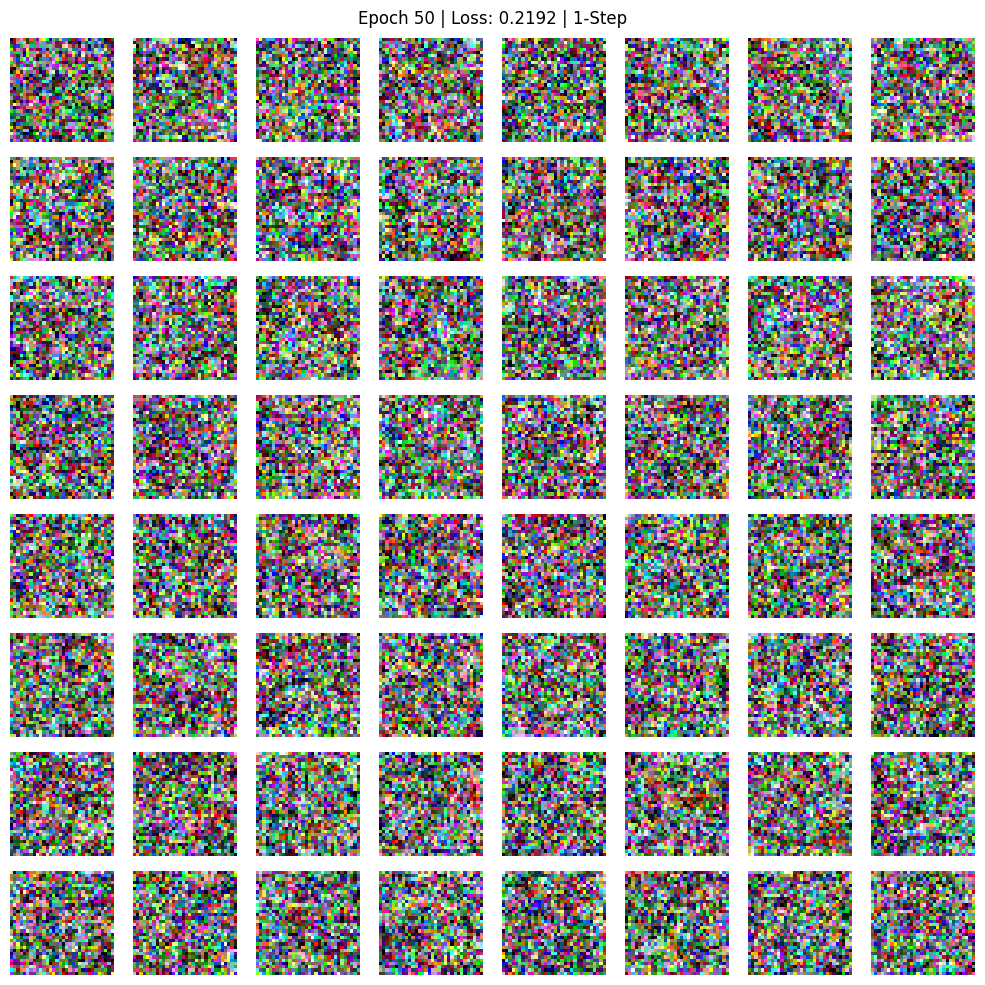

E51:   0%|          | 0/78 [00:00<?, ?it/s]

E52:   0%|          | 0/78 [00:00<?, ?it/s]

E53:   0%|          | 0/78 [00:00<?, ?it/s]

E54:   0%|          | 0/78 [00:00<?, ?it/s]

E55:   0%|          | 0/78 [00:00<?, ?it/s]

E56:   0%|          | 0/78 [00:00<?, ?it/s]

E57:   0%|          | 0/78 [00:00<?, ?it/s]

E58:   0%|          | 0/78 [00:00<?, ?it/s]

E59:   0%|          | 0/78 [00:00<?, ?it/s]

E60:   0%|          | 0/78 [00:00<?, ?it/s]

E 60 | Loss: 0.2134


E61:   0%|          | 0/78 [00:00<?, ?it/s]

E62:   0%|          | 0/78 [00:00<?, ?it/s]

E63:   0%|          | 0/78 [00:00<?, ?it/s]

E64:   0%|          | 0/78 [00:00<?, ?it/s]

E65:   0%|          | 0/78 [00:00<?, ?it/s]

E66:   0%|          | 0/78 [00:00<?, ?it/s]

E67:   0%|          | 0/78 [00:00<?, ?it/s]

E68:   0%|          | 0/78 [00:00<?, ?it/s]

E69:   0%|          | 0/78 [00:00<?, ?it/s]

E70:   0%|          | 0/78 [00:00<?, ?it/s]

E 70 | Loss: 0.2089


E71:   0%|          | 0/78 [00:00<?, ?it/s]

E72:   0%|          | 0/78 [00:00<?, ?it/s]

E73:   0%|          | 0/78 [00:00<?, ?it/s]

E74:   0%|          | 0/78 [00:00<?, ?it/s]

E75:   0%|          | 0/78 [00:00<?, ?it/s]

E76:   0%|          | 0/78 [00:00<?, ?it/s]

E77:   0%|          | 0/78 [00:00<?, ?it/s]

E78:   0%|          | 0/78 [00:00<?, ?it/s]

E79:   0%|          | 0/78 [00:00<?, ?it/s]

E80:   0%|          | 0/78 [00:00<?, ?it/s]

E 80 | Loss: 0.2066


E81:   0%|          | 0/78 [00:00<?, ?it/s]

E82:   0%|          | 0/78 [00:00<?, ?it/s]

E83:   0%|          | 0/78 [00:00<?, ?it/s]

E84:   0%|          | 0/78 [00:00<?, ?it/s]

E85:   0%|          | 0/78 [00:00<?, ?it/s]

E86:   0%|          | 0/78 [00:00<?, ?it/s]

E87:   0%|          | 0/78 [00:00<?, ?it/s]

E88:   0%|          | 0/78 [00:00<?, ?it/s]

E89:   0%|          | 0/78 [00:00<?, ?it/s]

E90:   0%|          | 0/78 [00:00<?, ?it/s]

E 90 | Loss: 0.2028


E91:   0%|          | 0/78 [00:00<?, ?it/s]

E92:   0%|          | 0/78 [00:00<?, ?it/s]

E93:   0%|          | 0/78 [00:00<?, ?it/s]

E94:   0%|          | 0/78 [00:00<?, ?it/s]

E95:   0%|          | 0/78 [00:00<?, ?it/s]

E96:   0%|          | 0/78 [00:00<?, ?it/s]

E97:   0%|          | 0/78 [00:00<?, ?it/s]

E98:   0%|          | 0/78 [00:00<?, ?it/s]

E99:   0%|          | 0/78 [00:00<?, ?it/s]

E100:   0%|          | 0/78 [00:00<?, ?it/s]

E100 | Loss: 0.2033
  Saved checkpoint


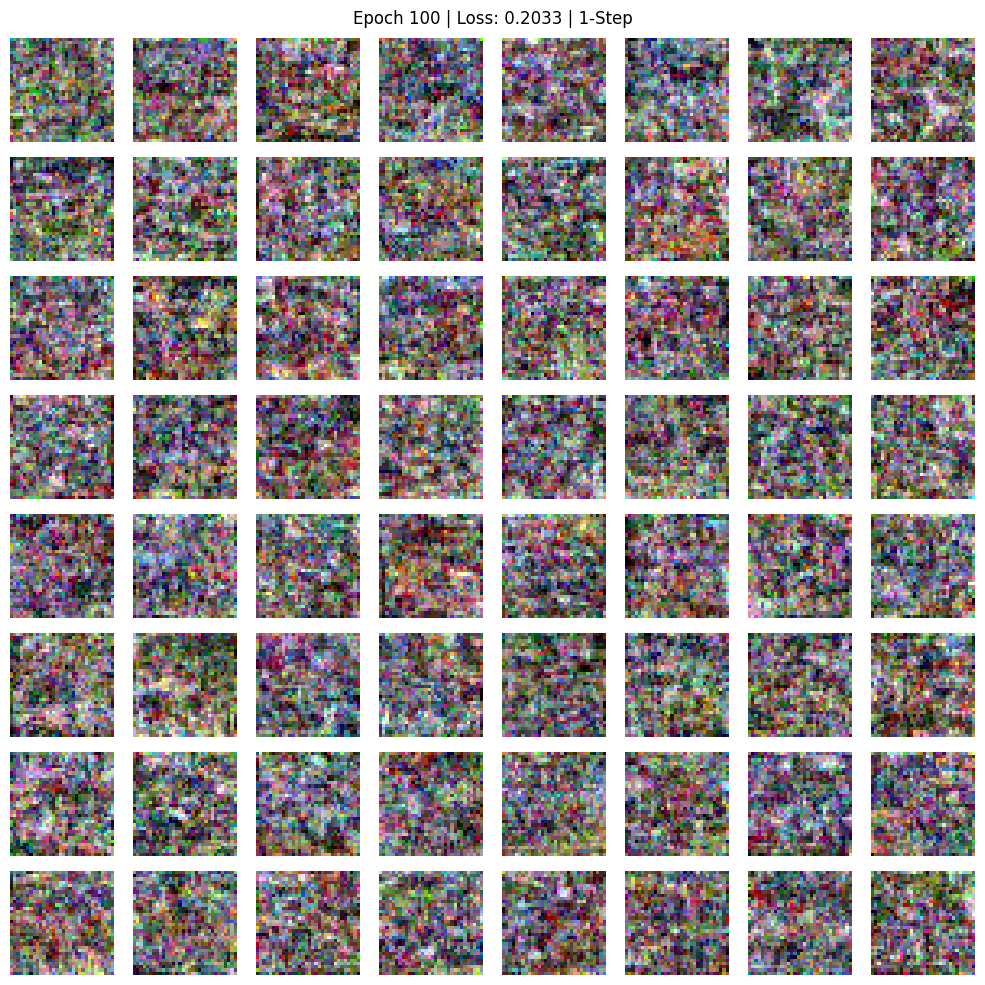

E101:   0%|          | 0/78 [00:00<?, ?it/s]

E102:   0%|          | 0/78 [00:00<?, ?it/s]

E103:   0%|          | 0/78 [00:00<?, ?it/s]

E104:   0%|          | 0/78 [00:00<?, ?it/s]

E105:   0%|          | 0/78 [00:00<?, ?it/s]

E106:   0%|          | 0/78 [00:00<?, ?it/s]

E107:   0%|          | 0/78 [00:00<?, ?it/s]

E108:   0%|          | 0/78 [00:00<?, ?it/s]

E109:   0%|          | 0/78 [00:00<?, ?it/s]

E110:   0%|          | 0/78 [00:00<?, ?it/s]

E110 | Loss: 0.1995


E111:   0%|          | 0/78 [00:00<?, ?it/s]

E112:   0%|          | 0/78 [00:00<?, ?it/s]

E113:   0%|          | 0/78 [00:00<?, ?it/s]

E114:   0%|          | 0/78 [00:00<?, ?it/s]

E115:   0%|          | 0/78 [00:00<?, ?it/s]

E116:   0%|          | 0/78 [00:00<?, ?it/s]

E117:   0%|          | 0/78 [00:00<?, ?it/s]

E118:   0%|          | 0/78 [00:00<?, ?it/s]

E119:   0%|          | 0/78 [00:00<?, ?it/s]

E120:   0%|          | 0/78 [00:00<?, ?it/s]

E120 | Loss: 0.1990


E121:   0%|          | 0/78 [00:00<?, ?it/s]

E122:   0%|          | 0/78 [00:00<?, ?it/s]

E123:   0%|          | 0/78 [00:00<?, ?it/s]

E124:   0%|          | 0/78 [00:00<?, ?it/s]

E125:   0%|          | 0/78 [00:00<?, ?it/s]

E126:   0%|          | 0/78 [00:00<?, ?it/s]

E127:   0%|          | 0/78 [00:00<?, ?it/s]

E128:   0%|          | 0/78 [00:00<?, ?it/s]

E129:   0%|          | 0/78 [00:00<?, ?it/s]

E130:   0%|          | 0/78 [00:00<?, ?it/s]

E130 | Loss: 0.2003


E131:   0%|          | 0/78 [00:00<?, ?it/s]

E132:   0%|          | 0/78 [00:00<?, ?it/s]

E133:   0%|          | 0/78 [00:00<?, ?it/s]

E134:   0%|          | 0/78 [00:00<?, ?it/s]

E135:   0%|          | 0/78 [00:00<?, ?it/s]

E136:   0%|          | 0/78 [00:00<?, ?it/s]

E137:   0%|          | 0/78 [00:00<?, ?it/s]

E138:   0%|          | 0/78 [00:00<?, ?it/s]

E139:   0%|          | 0/78 [00:00<?, ?it/s]

E140:   0%|          | 0/78 [00:00<?, ?it/s]

E140 | Loss: 0.1967


E141:   0%|          | 0/78 [00:00<?, ?it/s]

E142:   0%|          | 0/78 [00:00<?, ?it/s]

E143:   0%|          | 0/78 [00:00<?, ?it/s]

E144:   0%|          | 0/78 [00:00<?, ?it/s]

E145:   0%|          | 0/78 [00:00<?, ?it/s]

E146:   0%|          | 0/78 [00:00<?, ?it/s]

E147:   0%|          | 0/78 [00:00<?, ?it/s]

E148:   0%|          | 0/78 [00:00<?, ?it/s]

E149:   0%|          | 0/78 [00:00<?, ?it/s]

E150:   0%|          | 0/78 [00:00<?, ?it/s]

E150 | Loss: 0.1940
  Saved checkpoint


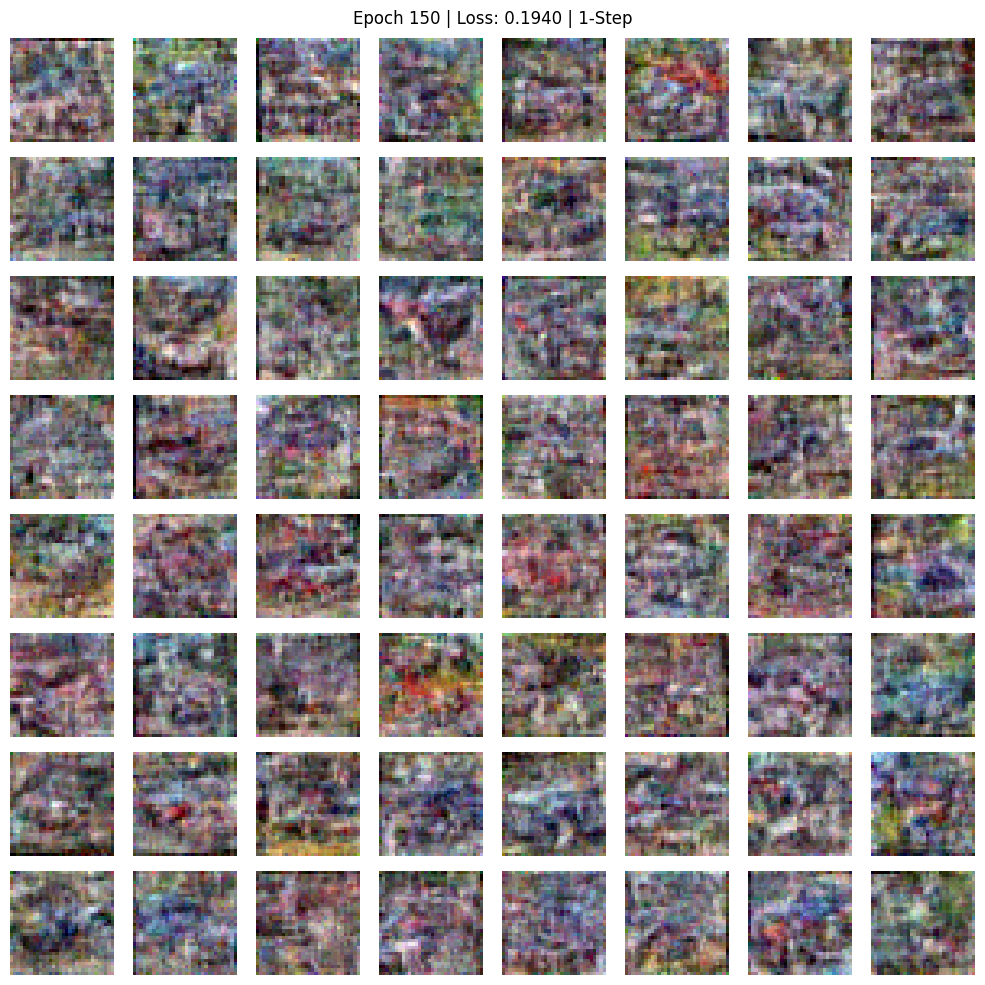

E151:   0%|          | 0/78 [00:00<?, ?it/s]

E152:   0%|          | 0/78 [00:00<?, ?it/s]

E153:   0%|          | 0/78 [00:00<?, ?it/s]

E154:   0%|          | 0/78 [00:00<?, ?it/s]

E155:   0%|          | 0/78 [00:00<?, ?it/s]

E156:   0%|          | 0/78 [00:00<?, ?it/s]

E157:   0%|          | 0/78 [00:00<?, ?it/s]

E158:   0%|          | 0/78 [00:00<?, ?it/s]

E159:   0%|          | 0/78 [00:00<?, ?it/s]

E160:   0%|          | 0/78 [00:00<?, ?it/s]

E160 | Loss: 0.1955


E161:   0%|          | 0/78 [00:00<?, ?it/s]

E162:   0%|          | 0/78 [00:00<?, ?it/s]

E163:   0%|          | 0/78 [00:00<?, ?it/s]

E164:   0%|          | 0/78 [00:00<?, ?it/s]

E165:   0%|          | 0/78 [00:00<?, ?it/s]

E166:   0%|          | 0/78 [00:00<?, ?it/s]

E167:   0%|          | 0/78 [00:00<?, ?it/s]

E168:   0%|          | 0/78 [00:00<?, ?it/s]

E169:   0%|          | 0/78 [00:00<?, ?it/s]

E170:   0%|          | 0/78 [00:00<?, ?it/s]

E170 | Loss: 0.1965


E171:   0%|          | 0/78 [00:00<?, ?it/s]

E172:   0%|          | 0/78 [00:00<?, ?it/s]

E173:   0%|          | 0/78 [00:00<?, ?it/s]

E174:   0%|          | 0/78 [00:00<?, ?it/s]

E175:   0%|          | 0/78 [00:00<?, ?it/s]

E176:   0%|          | 0/78 [00:00<?, ?it/s]

E177:   0%|          | 0/78 [00:00<?, ?it/s]

E178:   0%|          | 0/78 [00:00<?, ?it/s]

E179:   0%|          | 0/78 [00:00<?, ?it/s]

E180:   0%|          | 0/78 [00:00<?, ?it/s]

E180 | Loss: 0.1900


E181:   0%|          | 0/78 [00:00<?, ?it/s]

E182:   0%|          | 0/78 [00:00<?, ?it/s]

E183:   0%|          | 0/78 [00:00<?, ?it/s]

E184:   0%|          | 0/78 [00:00<?, ?it/s]

E185:   0%|          | 0/78 [00:00<?, ?it/s]

E186:   0%|          | 0/78 [00:00<?, ?it/s]

E187:   0%|          | 0/78 [00:00<?, ?it/s]

E188:   0%|          | 0/78 [00:00<?, ?it/s]

E189:   0%|          | 0/78 [00:00<?, ?it/s]

E190:   0%|          | 0/78 [00:00<?, ?it/s]

E190 | Loss: 0.1938


E191:   0%|          | 0/78 [00:00<?, ?it/s]

E192:   0%|          | 0/78 [00:00<?, ?it/s]

E193:   0%|          | 0/78 [00:00<?, ?it/s]

E194:   0%|          | 0/78 [00:00<?, ?it/s]

E195:   0%|          | 0/78 [00:00<?, ?it/s]

E196:   0%|          | 0/78 [00:00<?, ?it/s]

E197:   0%|          | 0/78 [00:00<?, ?it/s]

E198:   0%|          | 0/78 [00:00<?, ?it/s]

E199:   0%|          | 0/78 [00:00<?, ?it/s]

E200:   0%|          | 0/78 [00:00<?, ?it/s]

E200 | Loss: 0.1966
  Saved checkpoint


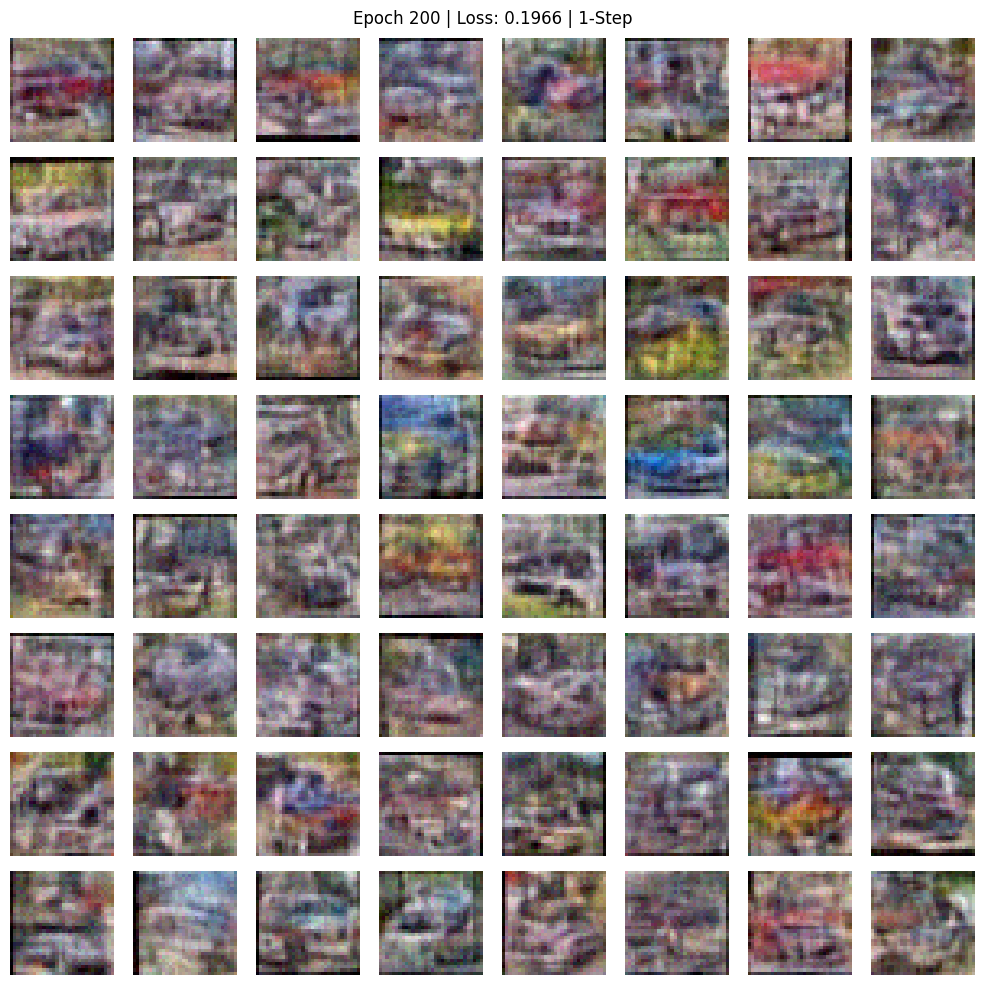

E201:   0%|          | 0/78 [00:00<?, ?it/s]

E202:   0%|          | 0/78 [00:00<?, ?it/s]

E203:   0%|          | 0/78 [00:00<?, ?it/s]

E204:   0%|          | 0/78 [00:00<?, ?it/s]

E205:   0%|          | 0/78 [00:00<?, ?it/s]

E206:   0%|          | 0/78 [00:00<?, ?it/s]

E207:   0%|          | 0/78 [00:00<?, ?it/s]

E208:   0%|          | 0/78 [00:00<?, ?it/s]

E209:   0%|          | 0/78 [00:00<?, ?it/s]

E210:   0%|          | 0/78 [00:00<?, ?it/s]

E210 | Loss: 0.1940


E211:   0%|          | 0/78 [00:00<?, ?it/s]

E212:   0%|          | 0/78 [00:00<?, ?it/s]

E213:   0%|          | 0/78 [00:00<?, ?it/s]

E214:   0%|          | 0/78 [00:00<?, ?it/s]

E215:   0%|          | 0/78 [00:00<?, ?it/s]

E216:   0%|          | 0/78 [00:00<?, ?it/s]

E217:   0%|          | 0/78 [00:00<?, ?it/s]

E218:   0%|          | 0/78 [00:00<?, ?it/s]

E219:   0%|          | 0/78 [00:00<?, ?it/s]

E220:   0%|          | 0/78 [00:00<?, ?it/s]

E220 | Loss: 0.1919


E221:   0%|          | 0/78 [00:00<?, ?it/s]

E222:   0%|          | 0/78 [00:00<?, ?it/s]

E223:   0%|          | 0/78 [00:00<?, ?it/s]

E224:   0%|          | 0/78 [00:00<?, ?it/s]

E225:   0%|          | 0/78 [00:00<?, ?it/s]

E226:   0%|          | 0/78 [00:00<?, ?it/s]

E227:   0%|          | 0/78 [00:00<?, ?it/s]

E228:   0%|          | 0/78 [00:00<?, ?it/s]

E229:   0%|          | 0/78 [00:00<?, ?it/s]

E230:   0%|          | 0/78 [00:00<?, ?it/s]

E230 | Loss: 0.1914


E231:   0%|          | 0/78 [00:00<?, ?it/s]

E232:   0%|          | 0/78 [00:00<?, ?it/s]

E233:   0%|          | 0/78 [00:00<?, ?it/s]

E234:   0%|          | 0/78 [00:00<?, ?it/s]

E235:   0%|          | 0/78 [00:00<?, ?it/s]

E236:   0%|          | 0/78 [00:00<?, ?it/s]

E237:   0%|          | 0/78 [00:00<?, ?it/s]

E238:   0%|          | 0/78 [00:00<?, ?it/s]

E239:   0%|          | 0/78 [00:00<?, ?it/s]

E240:   0%|          | 0/78 [00:00<?, ?it/s]

E240 | Loss: 0.1910


E241:   0%|          | 0/78 [00:00<?, ?it/s]

E242:   0%|          | 0/78 [00:00<?, ?it/s]

E243:   0%|          | 0/78 [00:00<?, ?it/s]

E244:   0%|          | 0/78 [00:00<?, ?it/s]

E245:   0%|          | 0/78 [00:00<?, ?it/s]

E246:   0%|          | 0/78 [00:00<?, ?it/s]

E247:   0%|          | 0/78 [00:00<?, ?it/s]

E248:   0%|          | 0/78 [00:00<?, ?it/s]

E249:   0%|          | 0/78 [00:00<?, ?it/s]

E250:   0%|          | 0/78 [00:00<?, ?it/s]

E250 | Loss: 0.1895
  Saved checkpoint


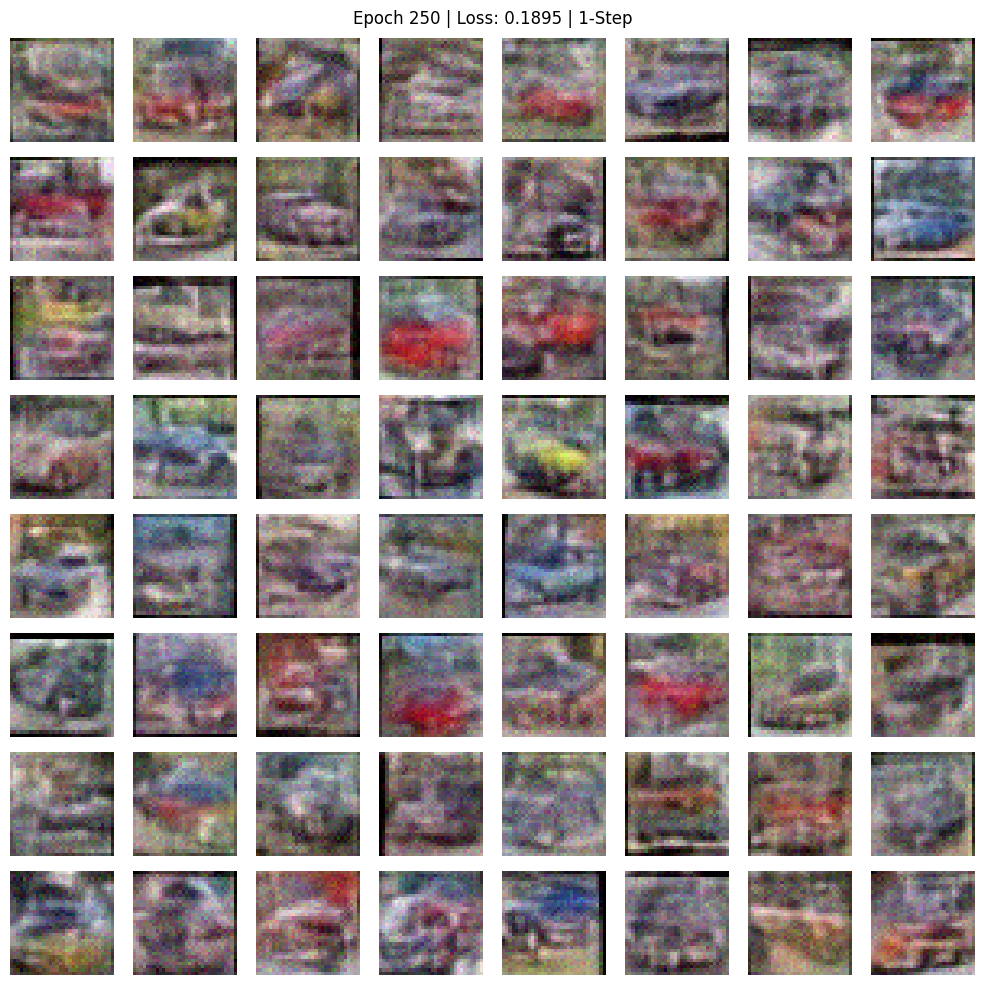

E251:   0%|          | 0/78 [00:00<?, ?it/s]

E252:   0%|          | 0/78 [00:00<?, ?it/s]

E253:   0%|          | 0/78 [00:00<?, ?it/s]

E254:   0%|          | 0/78 [00:00<?, ?it/s]

E255:   0%|          | 0/78 [00:00<?, ?it/s]

E256:   0%|          | 0/78 [00:00<?, ?it/s]

E257:   0%|          | 0/78 [00:00<?, ?it/s]

E258:   0%|          | 0/78 [00:00<?, ?it/s]

E259:   0%|          | 0/78 [00:00<?, ?it/s]

E260:   0%|          | 0/78 [00:00<?, ?it/s]

E260 | Loss: 0.1913


E261:   0%|          | 0/78 [00:00<?, ?it/s]

E262:   0%|          | 0/78 [00:00<?, ?it/s]

E263:   0%|          | 0/78 [00:00<?, ?it/s]

E264:   0%|          | 0/78 [00:00<?, ?it/s]

E265:   0%|          | 0/78 [00:00<?, ?it/s]

E266:   0%|          | 0/78 [00:00<?, ?it/s]

E267:   0%|          | 0/78 [00:00<?, ?it/s]

E268:   0%|          | 0/78 [00:00<?, ?it/s]

E269:   0%|          | 0/78 [00:00<?, ?it/s]

E270:   0%|          | 0/78 [00:00<?, ?it/s]

E270 | Loss: 0.1898


E271:   0%|          | 0/78 [00:00<?, ?it/s]

E272:   0%|          | 0/78 [00:00<?, ?it/s]

E273:   0%|          | 0/78 [00:00<?, ?it/s]

E274:   0%|          | 0/78 [00:00<?, ?it/s]

E275:   0%|          | 0/78 [00:00<?, ?it/s]

E276:   0%|          | 0/78 [00:00<?, ?it/s]

E277:   0%|          | 0/78 [00:00<?, ?it/s]

E278:   0%|          | 0/78 [00:00<?, ?it/s]

E279:   0%|          | 0/78 [00:00<?, ?it/s]

E280:   0%|          | 0/78 [00:00<?, ?it/s]

E280 | Loss: 0.1907


E281:   0%|          | 0/78 [00:00<?, ?it/s]

E282:   0%|          | 0/78 [00:00<?, ?it/s]

E283:   0%|          | 0/78 [00:00<?, ?it/s]

E284:   0%|          | 0/78 [00:00<?, ?it/s]

E285:   0%|          | 0/78 [00:00<?, ?it/s]

E286:   0%|          | 0/78 [00:00<?, ?it/s]

E287:   0%|          | 0/78 [00:00<?, ?it/s]

E288:   0%|          | 0/78 [00:00<?, ?it/s]

E289:   0%|          | 0/78 [00:00<?, ?it/s]

E290:   0%|          | 0/78 [00:00<?, ?it/s]

E290 | Loss: 0.1872


E291:   0%|          | 0/78 [00:00<?, ?it/s]

E292:   0%|          | 0/78 [00:00<?, ?it/s]

E293:   0%|          | 0/78 [00:00<?, ?it/s]

E294:   0%|          | 0/78 [00:00<?, ?it/s]

E295:   0%|          | 0/78 [00:00<?, ?it/s]

E296:   0%|          | 0/78 [00:00<?, ?it/s]

E297:   0%|          | 0/78 [00:00<?, ?it/s]

E298:   0%|          | 0/78 [00:00<?, ?it/s]

E299:   0%|          | 0/78 [00:00<?, ?it/s]

E300:   0%|          | 0/78 [00:00<?, ?it/s]

E300 | Loss: 0.1898
  Saved checkpoint


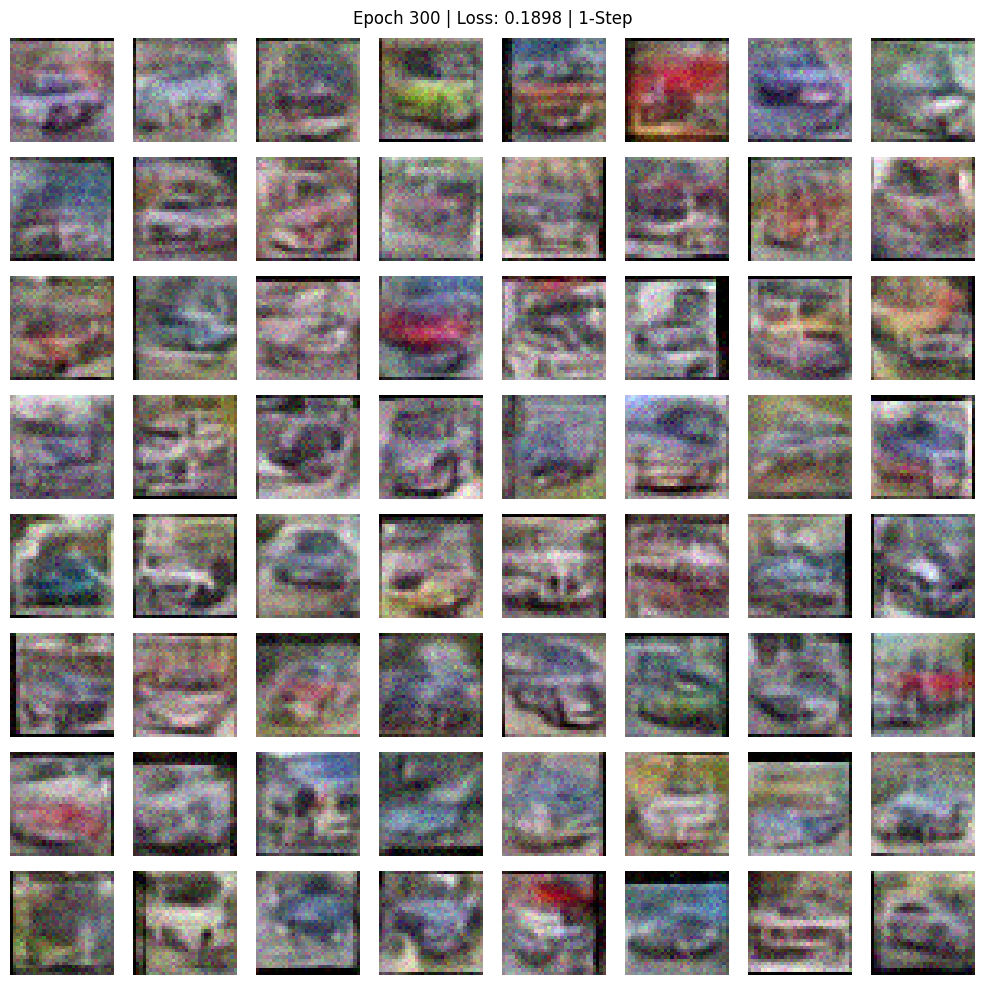

Training complete! Final loss: 0.1898


In [6]:
# Training Loop
dl = get_dataloader(bs=64, full=False)

for epoch in range(start_epoch, EPOCHS):
    model.train()
    epoch_loss = 0
    n_batches = 0

    for x, _ in tqdm(dl, desc=f"E{epoch+1}", leave=False):
        x = x.to(device, non_blocking=True)

        try:
            loss = meanflow_loss(model, x, device)

            if torch.isnan(loss) or loss.item() > 100:
                print(f"Skipping bad batch: loss={loss.item():.2f}")
                continue

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            ema.update(model)

            epoch_loss += loss.item()
            n_batches += 1

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("OOM! Clearing cache...")
                torch.cuda.empty_cache()
                continue
            raise

    avg_loss = epoch_loss / max(n_batches, 1)
    loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0 or epoch == start_epoch:
        print(f"E{epoch+1:3d} | Loss: {avg_loss:.4f}")

    if (epoch + 1) % SAVE_EVERY == 0:
        # Save checkpoint
        torch.save({
            "epoch": epoch + 1,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "ema": ema.shadow,
            "loss_history": loss_history
        }, CHECKPOINT)
        print(f"  Saved checkpoint")

        # Sample with EMA
        model.eval()
        ema.apply(model)
        samples = sample_1step(model, 64, device)
        ema.restore(model)

        # Visualize
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        fig.suptitle(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | 1-Step")
        for i, ax in enumerate(axes.flat):
            img = samples[i].cpu().permute(1, 2, 0).numpy()
            ax.imshow(np.clip(img, 0, 1))
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"results/samples_e{epoch+1}.png", dpi=150)
        plt.show()

        torch.cuda.empty_cache()

print(f"Training complete! Final loss: {loss_history[-1]:.4f}")

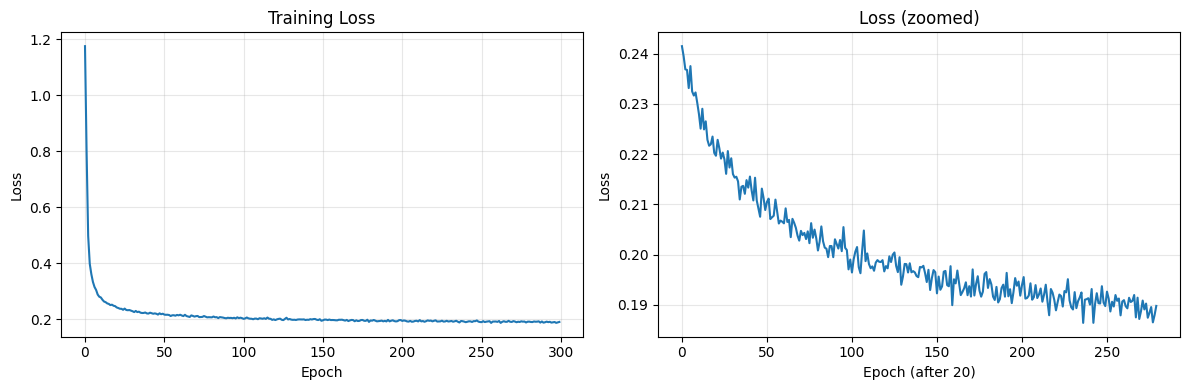

Initial: 1.1748
Final: 0.1898


In [7]:
# Loss curve
if loss_history:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    if len(loss_history) > 20:
        plt.plot(loss_history[20:])
        plt.xlabel("Epoch (after 20)")
        plt.ylabel("Loss")
        plt.title("Loss (zoomed)")
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/loss_curve.png", dpi=150)
    plt.show()

    print(f"Initial: {loss_history[0]:.4f}")
    print(f"Final: {loss_history[-1]:.4f}")

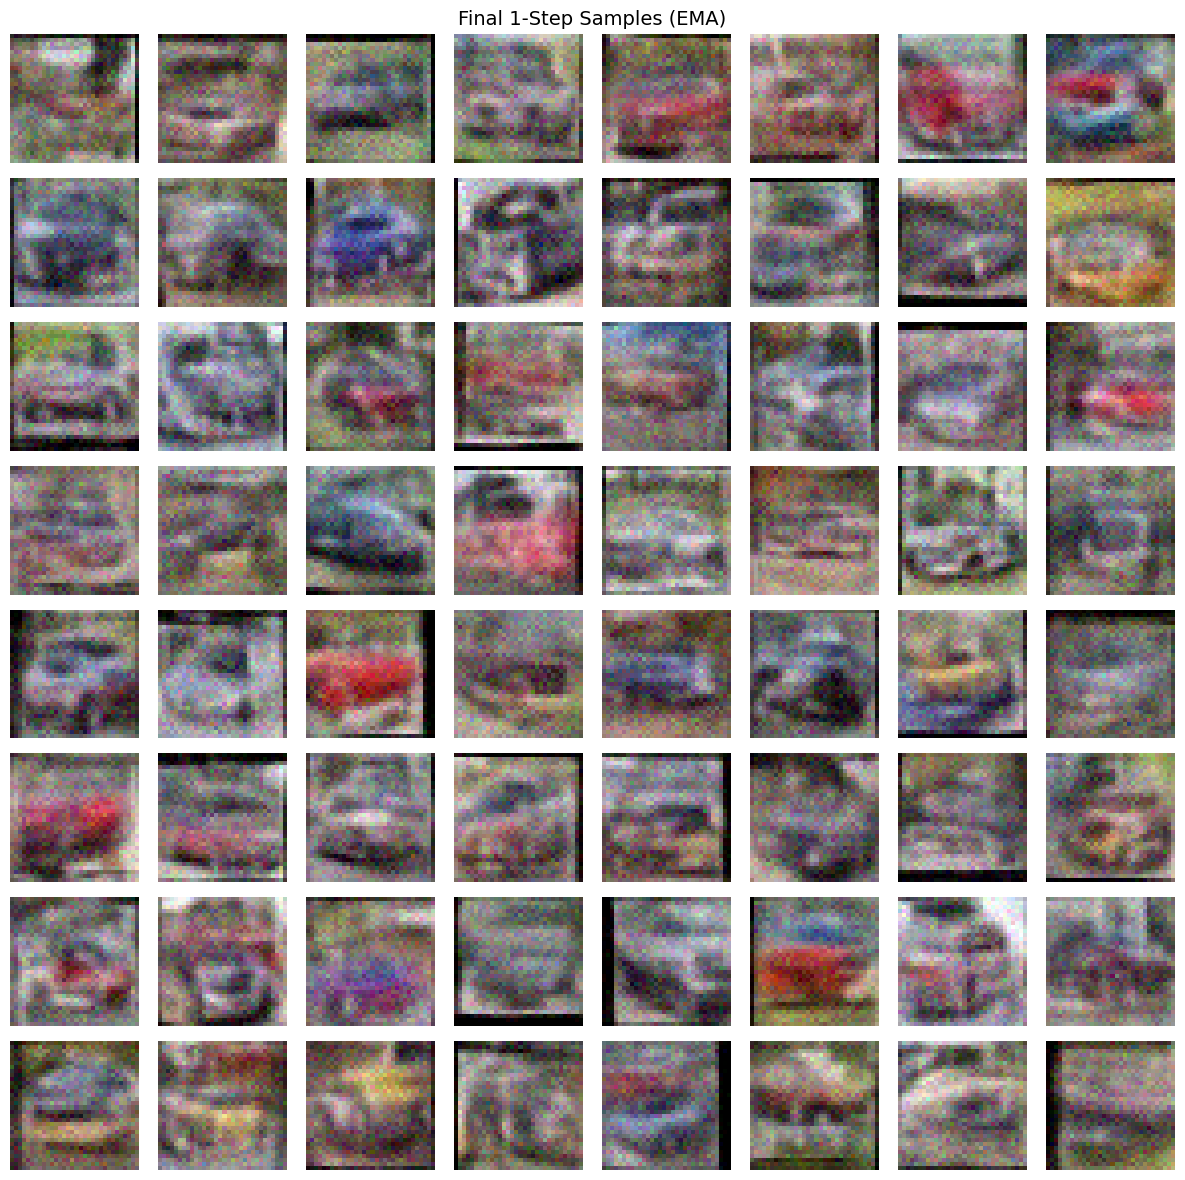

In [8]:
# Final samples with EMA
model.eval()
ema.apply(model)

final_samples = sample_1step(model, 64, device)

ema.restore(model)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle("Final 1-Step Samples (EMA)", fontsize=14)
for i, ax in enumerate(axes.flat):
    img = final_samples[i].cpu().permute(1, 2, 0).numpy()
    ax.imshow(np.clip(img, 0, 1))
    ax.axis("off")
plt.tight_layout()
plt.savefig("results/final_samples.png", dpi=150)
plt.show()